# CS506 Team Project TP03 – Deep Learning with PyTorch: Dance Move Detector  
Topic: Pose-based Dance Move Classification using CNN or LSTM  
Team Members: Veronica Elze, Hiromi Cota, & Ixius Procopios

# 🧩 STEP 0: Imports & Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import numpy as np
import json
import matplotlib.pyplot as plt
from pathlib import Path
import os

# Reuse logic from previous submissions
from pose_tools_byH import poses_to_vectors

# 📥 STEP 1: Load and Prepare Dataset

In [2]:
class DancePoseDataset(Dataset):
    def __init__(self, poses_dir):
        self.samples = []
        self.labels = []
        self.label_dict = {}
        files = [f for f in os.listdir(poses_dir) if f.endswith('.json')]
        for idx, f in enumerate(files):
            label_name = f.split('_')[0]  # Extract label from filename
            if label_name not in self.label_dict:
                self.label_dict[label_name] = len(self.label_dict)

            try:
                with open(os.path.join(poses_dir, f), 'r') as file:
                    data = json.load(file)
                keypoints = data[0]['people'][0]['pose_keypoints_2d']
                keypoints = np.array(keypoints).reshape(-1, 3)[:, :2]
                self.samples.append(keypoints.flatten())
                self.labels.append(self.label_dict[label_name])
            except Exception as e:
                print(f"Skipping file {f} due to error: {e}")

        # Standardize features
        self.scaler = StandardScaler()
        self.samples = self.scaler.fit_transform(self.samples)
        self.samples = torch.tensor(self.samples, dtype=torch.float32)
        self.labels = torch.tensor(self.labels, dtype=torch.long)

        # Visualization: Sample distribution
        self.visualize_sample_distribution()

    def visualize_sample_distribution(self):
        labels, counts = np.unique(self.labels.numpy(), return_counts=True)
        plt.bar(labels, counts, tick_label=[label for label, idx in self.label_dict.items()])
        plt.title("Distribution of Dance Pose Samples")
        plt.xlabel("Dance Pose")
        plt.ylabel("Count")
        plt.show()

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]

# 🧠 STEP 2: Define Neural Network (CNN)

In [3]:
class DanceNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(DanceNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

# 🎯 STEP 3: Train the Network

In [4]:
def train(model, dataloader, criterion, optimizer, epochs=20):
    loss_values = []
    for epoch in range(epochs):
        epoch_loss = 0
        for x, y in dataloader:
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        epoch_loss /= len(dataloader)
        loss_values.append(epoch_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")
        
        # Interim Loss Visualization every 5 epochs
        if (epoch + 1) % 5 == 0:
            plt.plot(loss_values)
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title(f"Training Loss Curve (Epoch {epoch+1})")
            plt.grid(True)
            plt.show()
            
    return loss_values

# 🔍 STEP 4: Evaluate the Model

In [5]:
def evaluate(model, dataloader):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x, y in dataloader:
            outputs = model(x)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(y.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    acc = accuracy_score(all_labels, all_preds)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(len(set(all_labels)))))
    disp.plot()
    plt.title(f'Confusion Matrix (Accuracy: {acc:.2%})')
    plt.show()

# 📊 STEP 5: Plot Loss Curve

In [6]:
def plot_loss_curve(losses):
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Final Training Loss Curve")
    plt.grid(True)
    plt.show()

# 🚀 STEP 6: Main Execution Block

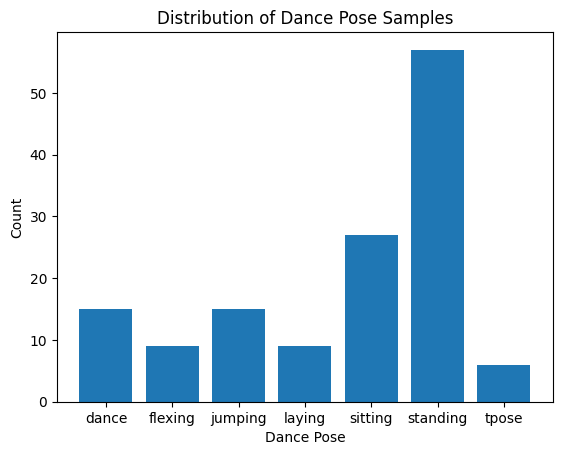

Epoch 1/20, Loss: 1.7425
Epoch 2/20, Loss: 1.3104
Epoch 3/20, Loss: 1.0899
Epoch 4/20, Loss: 0.9327
Epoch 5/20, Loss: 0.8025


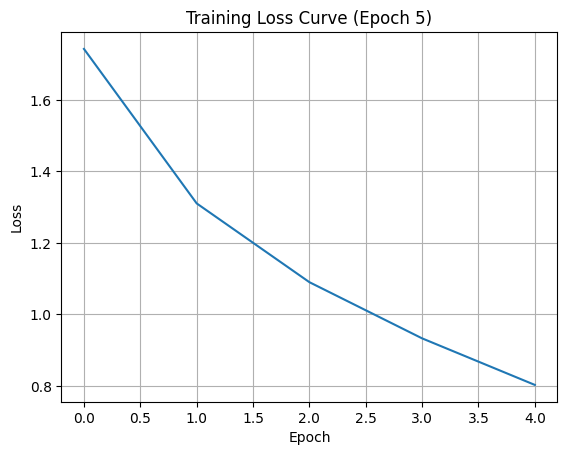

Epoch 6/20, Loss: 0.6996
Epoch 7/20, Loss: 0.6153
Epoch 8/20, Loss: 0.5251
Epoch 9/20, Loss: 0.4582
Epoch 10/20, Loss: 0.3952


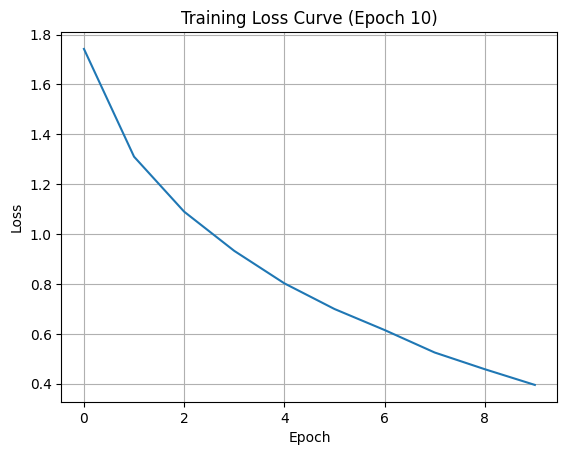

Epoch 11/20, Loss: 0.3542
Epoch 12/20, Loss: 0.3130
Epoch 13/20, Loss: 0.2683
Epoch 14/20, Loss: 0.2431
Epoch 15/20, Loss: 0.2095


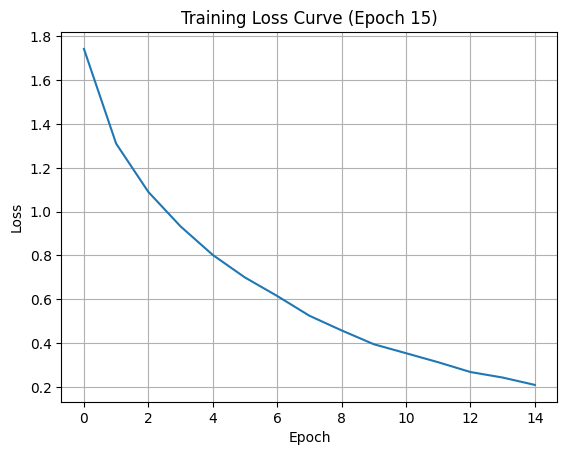

Epoch 16/20, Loss: 0.1867
Epoch 17/20, Loss: 0.1636
Epoch 18/20, Loss: 0.1496
Epoch 19/20, Loss: 0.1295
Epoch 20/20, Loss: 0.1136


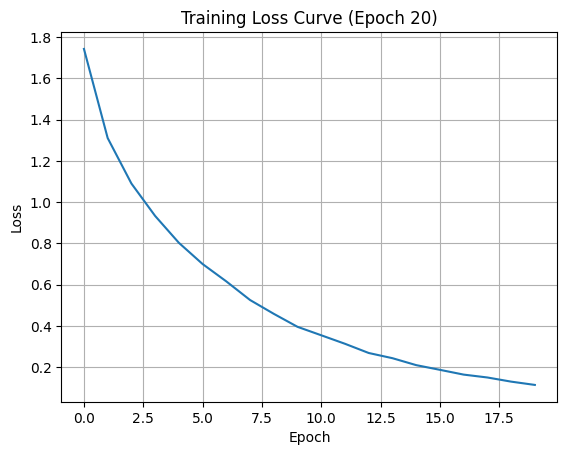

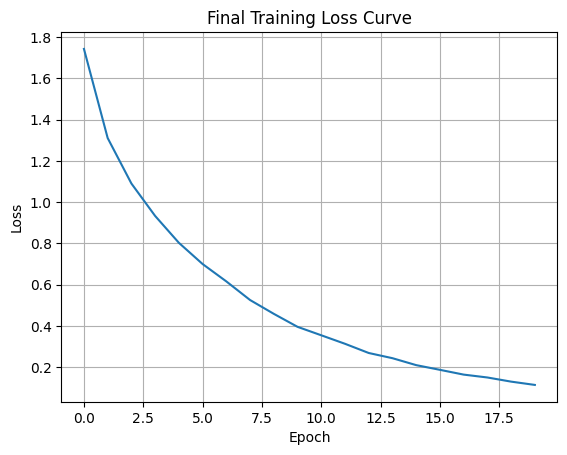

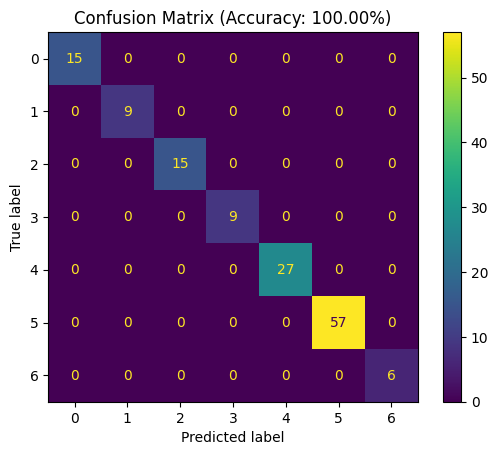

Model saved to sub3_dancemoves_model.pt


In [7]:
if __name__ == '__main__':
    poses_dir = Path("./poses")
    dataset = DancePoseDataset(poses_dir)
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

    input_size = dataset.samples.shape[1]
    num_classes = len(dataset.label_dict)

    model = DanceNet(input_size, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    loss_history = train(model, dataloader, criterion, optimizer, epochs=20)

    plot_loss_curve(loss_history)
    evaluate(model, dataloader)

    model_save_path = Path("./sub3_dancemoves_model.pt")
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

# REFERENCES 

OpenAI. (2025). ChatGPT’s assistance with CS506 TP03 Dance Detector [Large language model]. https://openai.com/chatgpt  
PyTorch. (n.d.). https://pytorch.org/docs/stable/index.html  
Scikit-Learn. (n.d.). StandardScaler, accuracy_score, confusion_matrix. https://scikit-learn.org/stable/modules/classes.html